<a href="https://colab.research.google.com/github/ruanvirginio/scriptsMestrado/blob/main/transformaBaseST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import plotly.express as px
import numpy as np
import os
import warnings

warnings.filterwarnings("ignore")

url = "https://media.githubusercontent.com/media/ruanvirginio/scriptsMestrado/refs/heads/main/demandaTrafos_2018-2023.csv"

df = pd.read_csv(url,  sep=';', encoding='latin-1')

# Função para aplicar o filtro IQR
def filtrar_coluna_iqr(df, coluna):
    Q1 = df[coluna].quantile(0.25)
    Q3 = df[coluna].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return df[(df[coluna] >= lower_bound) & (df[coluna] <= upper_bound)]

# Função para aplicar o filtro baseado em Média Móvel
def filtrar_coluna_media_movel(df, coluna, janela=20, threshold=4):

    media_movel = df[coluna].rolling(window=janela, center=True).mean()
    desvio = np.abs(df[coluna] - media_movel)

    # Determinando o limite de outliers baseado no desvio padrão local
    limite_superior = media_movel + threshold * desvio.std()
    limite_inferior = media_movel - threshold * desvio.std()

    return df[(df[coluna] >= limite_inferior) & (df[coluna] <= limite_superior)]

# Função para aplicar o filtro baseado em Z-Score
def filtrar_coluna_zscore(df, coluna, threshold=3):
    media = df[coluna].mean()
    desvio_padrao = df[coluna].std()
    z_scores = (df[coluna] - media) / desvio_padrao

    # Filtrando os valores cujo Z-Score seja menor que o threshold
    return df[np.abs(z_scores) < threshold]


# Função que aplica o filtro escolhido
def aplicar_filtro(df, coluna, metodo='iqr', janela=20, threshold=4, z_threshold=3):
    if metodo == 'iqr':
        return filtrar_coluna_iqr(df, coluna)
    elif metodo == 'media_movel':
        return filtrar_coluna_media_movel(df, coluna, janela=janela, threshold=threshold)
    elif metodo == 'zscore':
        return filtrar_coluna_zscore(df, coluna, threshold=z_threshold)
    else:
        raise ValueError("Método inválido! Escolha entre 'iqr', 'media_movel' ou 'zscore'.")



# Renomeando as colunas
df.rename(columns={
    'Potencia Ativa': 'P',
    'Potencia Reativa': 'Q',
    'Data/Hora Medição': 'datahora'
}, inplace=True)

# Convertendo para datetime e salvando o módulo dos valores, pois pode ocorrer valores negativos
df['datahora'] = pd.to_datetime(df['datahora'], dayfirst=True, errors='coerce')
df['P'] = df['P'].abs()  # salvando o módulo dos valores
df['Q'] = df['Q'].abs()  # salvando o módulo dos valores
df['S'] = np.sqrt(df['P']**2 + df['Q']**2)  # Calculando a potência aparente (S), em kVA

# Removendo linhas com S = 0
df = df[df['S'] != 0]

# DataFrame final para armazenar os dados filtrados
df_filtrado = pd.DataFrame()

# Escolha do método de filtragem ('iqr', 'media_movel' ou 'zscore')
metodo_filtro = 'media_movel'

# Percorrendo cada transformador
for trafo in df['TRAFO'].unique():
    df_trafo = df[df['TRAFO'] == trafo]

    # Aplicando o filtro escolhido
    df_trafo_filtrado = aplicar_filtro(df_trafo, 'S', metodo=metodo_filtro, janela=20, threshold=4, z_threshold=3)

    # Adicionar os dados filtrados ao DataFrame final
    df_filtrado = pd.concat([df_filtrado, df_trafo_filtrado], ignore_index=True)

# Ordenando e removendo duplicatas
df_filtrado = df_filtrado.sort_values(by=['TRAFO', 'datahora'])
df_filtrado = df_filtrado.drop_duplicates(subset=['datahora', 'TRAFO'])

# Criando gráfico da Potência Aparente ao longo do tempo, separada por TRAFO
fig_aparente = px.line(df_filtrado, x='datahora', y='S', color='TRAFO',
                       title='Potência Aparente ao Longo do Tempo por Transformador',
                       labels={'S': 'Potência Aparente (kVA)', 'Dia': 'Data'})

# Exibir ou salvar o gráfico em
# fig_aparente.show()
# fig_aparente.write_html("Demanda ao longo do tempo - IQR.html")



## Preparação do conjunto de treino/teste

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step


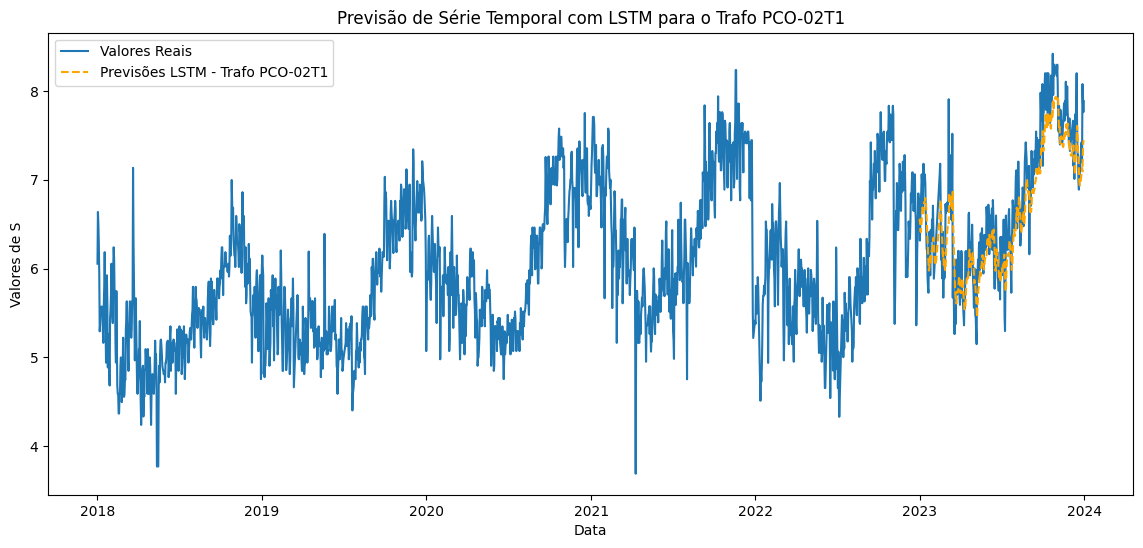

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step


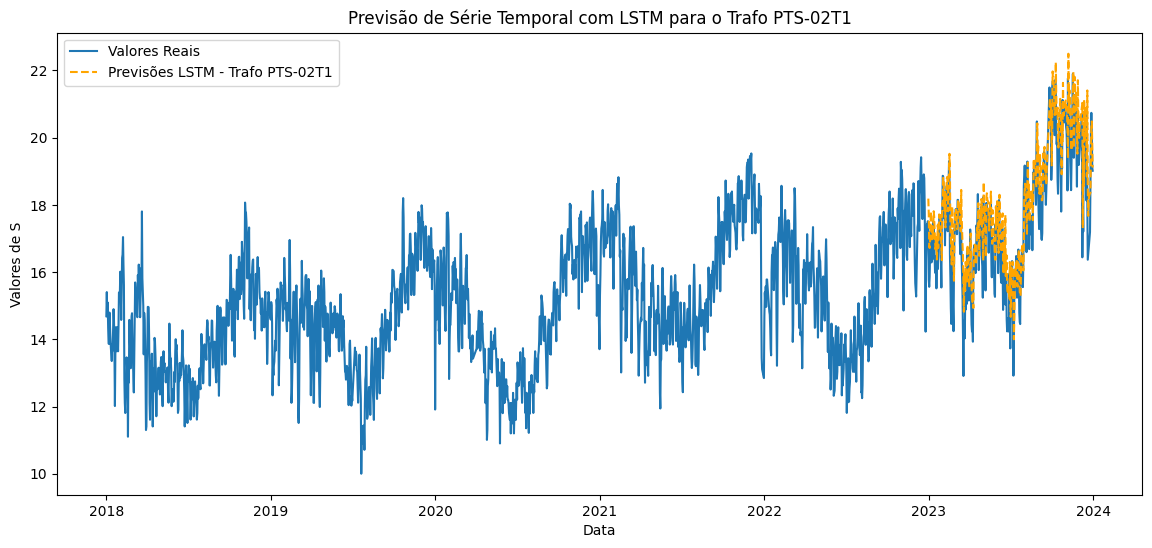

      Trafo       MSE      RMSE
0  PCO-02T1  0.122783  0.350404
1  PTS-02T1  1.081512  1.039958


In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler

def treinar_e_prever_LSTM(df_filtrado, trafos_escolhidos, epochs=20, batch_size=32, janela=365):
    resultados = []

    for trafo in trafos_escolhidos:
        # Filtrar dados do transformador atual
        df = df_filtrado[df_filtrado['TRAFO'] == trafo]
        df = df[['datahora', 'S']]
        df = df.set_index(['datahora'])
        df = df.resample('D').max()
        df.sort_index(inplace=True)
        df['S'] = df['S'].interpolate()

        # Normalização dos dados
        dados = df[['S']].values
        scaler = MinMaxScaler(feature_range=(0, 1))
        dados_normalizados = scaler.fit_transform(dados)

        # Configuração da janela deslizante e criação de X e y
        X, y = [], []
        for i in range(janela, len(dados_normalizados)):
            X.append(dados_normalizados[i-janela:i, 0])
            y.append(dados_normalizados[i, 0])

        X, y = np.array(X), np.array(y)
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))

        # Divisão dos dados em treino e teste (80/20)
        split = int(len(X) * 0.8)
        X_train, X_test = X[:split], X[split:]
        y_train, y_test = y[:split], y[split:]

        # Construindo o modelo LSTM
        model = Sequential()
        model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
        model.add(LSTM(units=50))
        model.add(Dense(1))

        model.compile(optimizer='adam', loss='mean_squared_error')
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

        # Fazendo previsões no conjunto de teste
        y_pred_normalizado = model.predict(X_test)
        y_pred = scaler.inverse_transform(y_pred_normalizado)
        y_test_inverso = scaler.inverse_transform(y_test.reshape(-1, 1))

        # Cálculo dos erros
        mse = mean_squared_error(y_test_inverso, y_pred)
        rmse = sqrt(mse)

        # Ajustando o índice para os dados de previsão
        df_previsoes = df.index[split + janela:]

        # Visualizando os resultados
        plt.figure(figsize=(14, 6))
        plt.plot(df.index, df['S'], label='Valores Reais')
        plt.plot(df_previsoes, y_pred, label=f'Previsões LSTM - Trafo {trafo}', linestyle='--', color='orange')
        plt.xlabel('Data')
        plt.ylabel('Valores de S')
        plt.title(f'Previsão de Série Temporal com LSTM para o Trafo {trafo}')
        plt.legend()
        plt.show()

        # Armazenando os resultados em uma lista
        resultados.append({'Trafo': trafo, 'MSE': mse, 'RMSE': rmse})

    # Retornando os resultados como DataFrame
    return pd.DataFrame(resultados)

# Supondo que df_filtrado já está preparado com todos os dados dos transformadores

# Lista de transformadores para análise
trafos_escolhidos = ['PCO-02T1', 'PTS-02T1']  # Exemplo de transformadores

# Chamando a função e obtendo os resultados
resultados = treinar_e_prever_LSTM(df_filtrado, trafos_escolhidos, epochs=20, batch_size=32, janela=365)

# Exibindo a tabela de resultados
print(resultados)


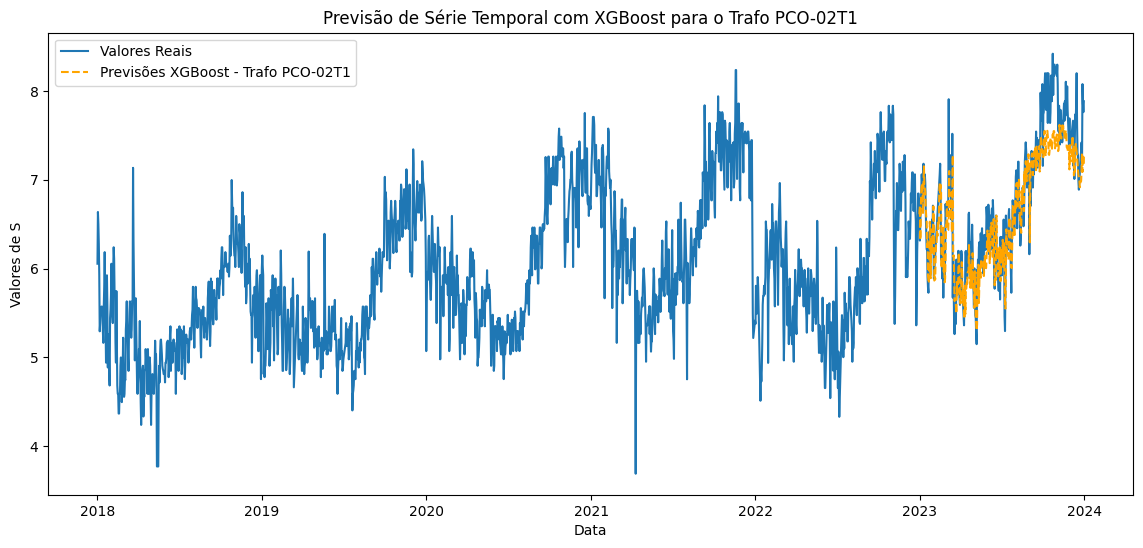

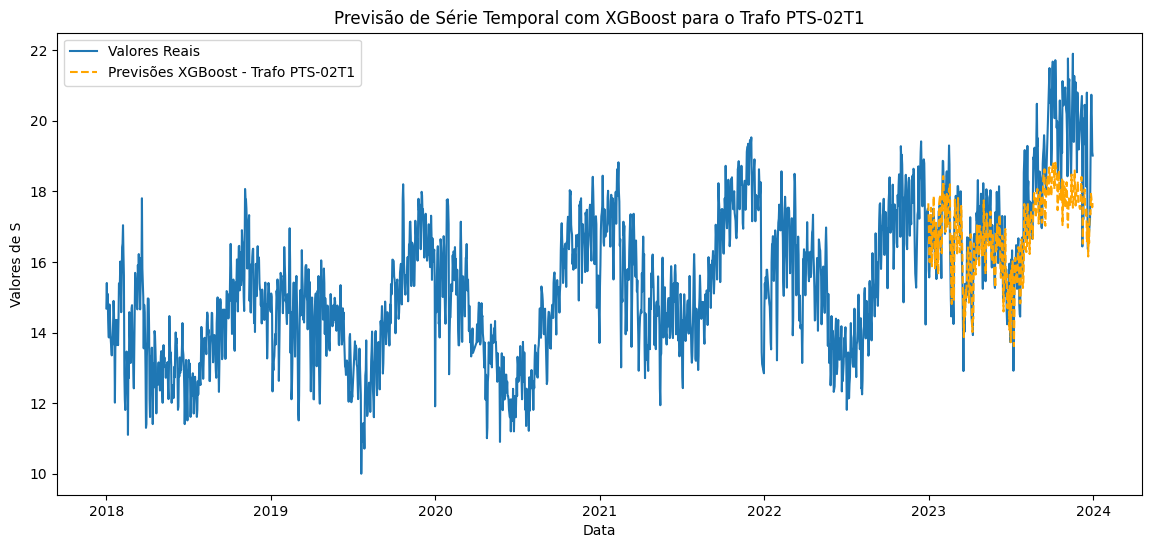

      Trafo       MSE      RMSE
0  PCO-02T1  0.133177  0.364934
1  PTS-02T1  1.929350  1.389010


In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler

def treinar_e_prever_XGBoost(df_filtrado, trafos_escolhidos, n_estimators=1000, learning_rate=0.01, janela=365):
    resultados = []

    for trafo in trafos_escolhidos:
        # Filtrar dados do transformador atual
        df = df_filtrado[df_filtrado['TRAFO'] == trafo]
        df = df[['datahora', 'S']]
        df = df.set_index(['datahora'])
        df = df.resample('D').max()
        df.sort_index(inplace=True)
        df['S'] = df['S'].interpolate()

        # Normalização dos dados
        dados = df[['S']].values
        scaler = MinMaxScaler(feature_range=(0, 1))
        dados_normalizados = scaler.fit_transform(dados)

        # Configuração da janela deslizante e criação de X e y
        X, y = [], []
        for i in range(janela, len(dados_normalizados)):
            X.append(dados_normalizados[i-janela:i, 0])
            y.append(dados_normalizados[i, 0])

        X, y = np.array(X), np.array(y)

        # Divisão dos dados em treino e teste (80/20)
        split = int(len(X) * 0.8)
        X_train, X_test = X[:split], X[split:]
        y_train, y_test = y[:split], y[split:]

        # Ajustando a forma do X para o XGBoost
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

        # Construindo o modelo XGBoost
        model = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate)
        model.fit(X_train, y_train)

        # Fazendo previsões no conjunto de teste
        y_pred_normalizado = model.predict(X_test)
        y_pred = scaler.inverse_transform(y_pred_normalizado.reshape(-1, 1))
        y_test_inverso = scaler.inverse_transform(y_test.reshape(-1, 1))

        # Cálculo dos erros
        mse = mean_squared_error(y_test_inverso, y_pred)
        rmse = sqrt(mse)

        # Ajustando o índice para os dados de previsão
        df_previsoes = df.index[split + janela:]

        # Visualizando os resultados
        plt.figure(figsize=(14, 6))
        plt.plot(df.index, df['S'], label='Valores Reais')
        plt.plot(df_previsoes, y_pred, label=f'Previsões XGBoost - Trafo {trafo}', linestyle='--', color='orange')
        plt.xlabel('Data')
        plt.ylabel('Valores de S')
        plt.title(f'Previsão de Série Temporal com XGBoost para o Trafo {trafo}')
        plt.legend()
        plt.show()

        # Armazenando os resultados em uma lista
        resultados.append({'Trafo': trafo, 'MSE': mse, 'RMSE': rmse})

    # Retornando os resultados como DataFrame
    return pd.DataFrame(resultados)


n_estimators = 1000
learning_rate = 0.01
janela = 365

resultados = treinar_e_prever_XGBoost(df_filtrado, trafo_escolhido, n_estimators=n_estimators, learning_rate=learning_rate, janela=janela)
print(resultados)
